In [1]:
################################################################################################################
# Author: Animesh Kumar Paul(animeshk@ualberta.ca)                                                             #
# Special thanks to Andy for sharing the tolerance interval code                                               #
#                                                                                                              #                                                          #
################################################################################################################

In [2]:
import numpy as np
import pandas as pd
import pickle
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from scipy.stats import sem
from numba import objmode, jit
from scipy.stats import binom

In [3]:
def load_path_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [7]:
data_path = r'C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting'
plots_path = r'.\results\Plots'
total_steps = 250000

In [5]:
fidelity = 200
alpha = 1
def pullLeft(x, p):
    if x < 0:
        return (1 + p) * x

    return (1 - p) * x

def pullRight(x, p):
    return -pullLeft(-x, p)

In [6]:
###Added:
def confidenceInterval(mean, stderr, runs):
    #return (mean - 1.96 * stderr, mean + 1.96 * stderr)
    if runs==30:
        return (mean - 2.045 * stderr, mean + 2.045 * stderr) # for 30
    else:
        return (mean - 2.145 * stderr, mean + 2.145 * stderr) #for 15

In [7]:
###Tolerance Interval

def ppf(n: int, alpha: float, beta: float):
    return binom.ppf(1 - alpha, n, beta)

def getToleranceIndices(n: int, alpha: float, beta: float):
    # we cannot jit compile most things from scipy.stats
    # so perform a callback to the python interpreter to obtain this value
    y = 0.
    with objmode(y='float64'):
        y = ppf(n, alpha, beta)

    nu = int(n - y)

    # figure out indices
    if nu % 2 == 0:
        l = int(nu/2)
        u = int(n - (nu/2)) - 1
    else:
        nu1 = (nu/2) - (1/2)
        l = int(nu1)
        u = int(n - (nu1 + 1))

    return l, u

def toleranceIntervalOverCurve(data: np.ndarray, alpha=0.05, beta=0.9):
    n = data.shape[0]

    l, u = getToleranceIndices(n, alpha, beta)
    print(l, u)

    out = np.zeros((3, data.shape[1]))
    for i in range(data.shape[1]):
        d = np.sort(data[:, i])
        out[0, i] = d[l]
        out[1, i] = np.mean(data[:, i])
        out[2, i] = d[u]

    return out

### Plot Reward Distribution, Confidence Interval, and Tolerance Interval

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_1.pkl
Total Runs:  30


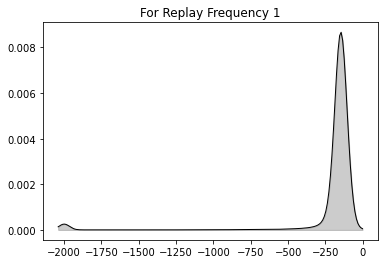

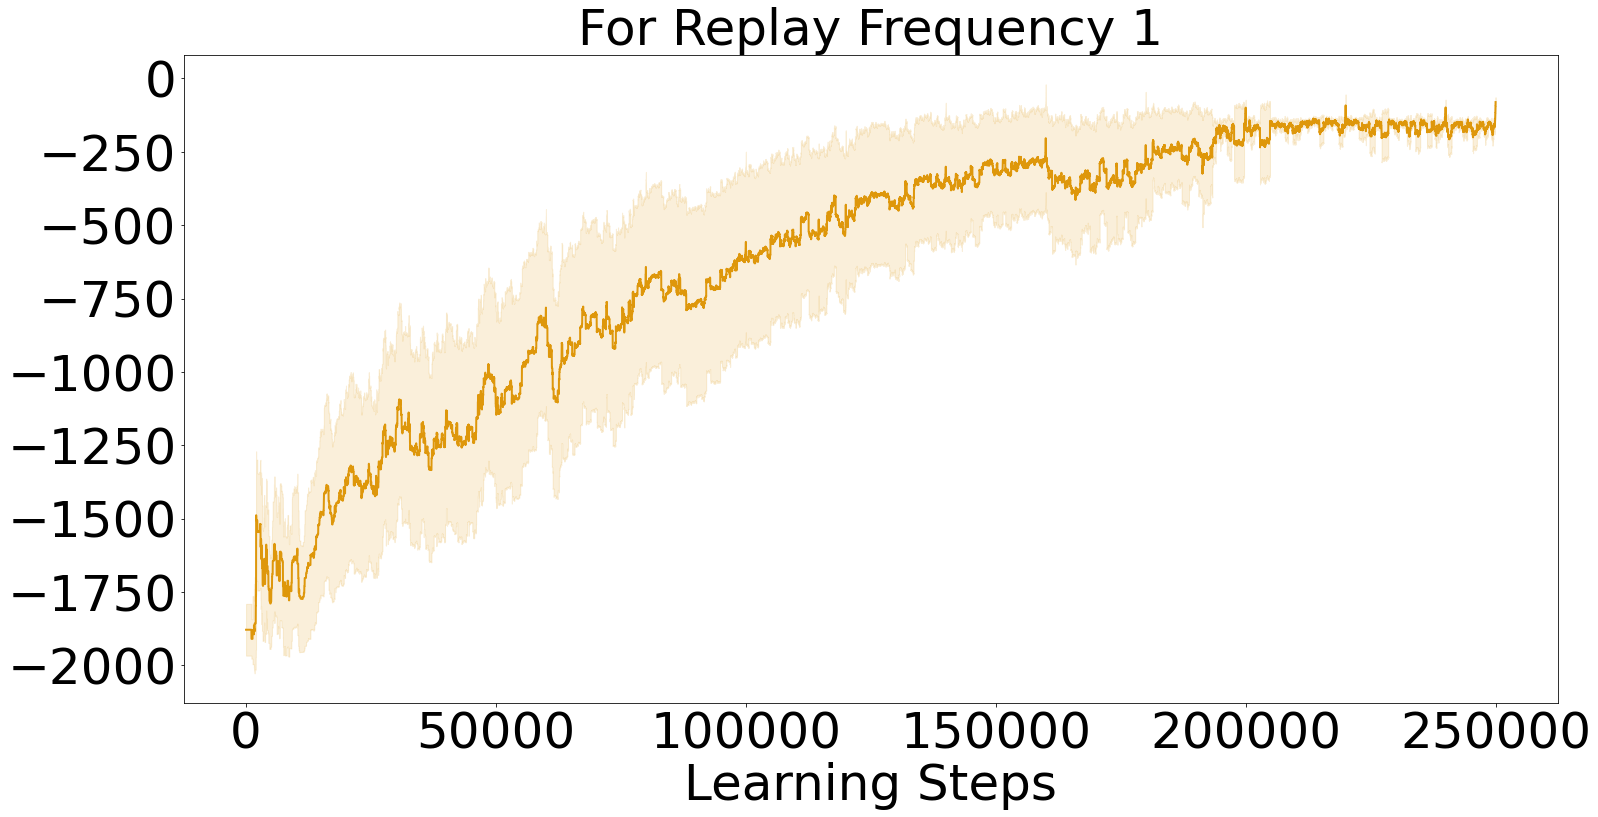

0 29


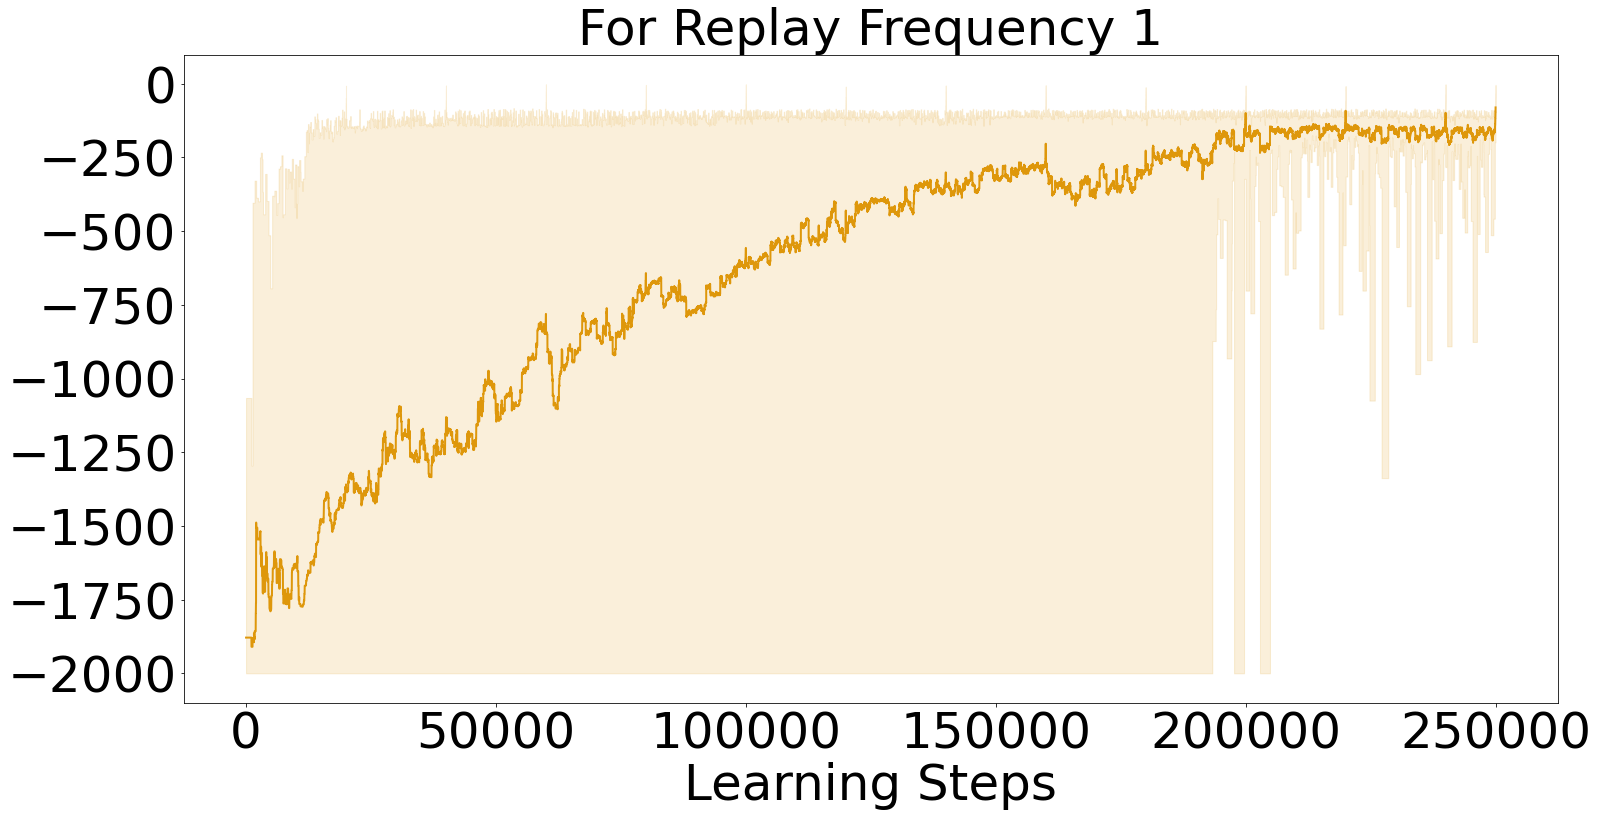

0 29


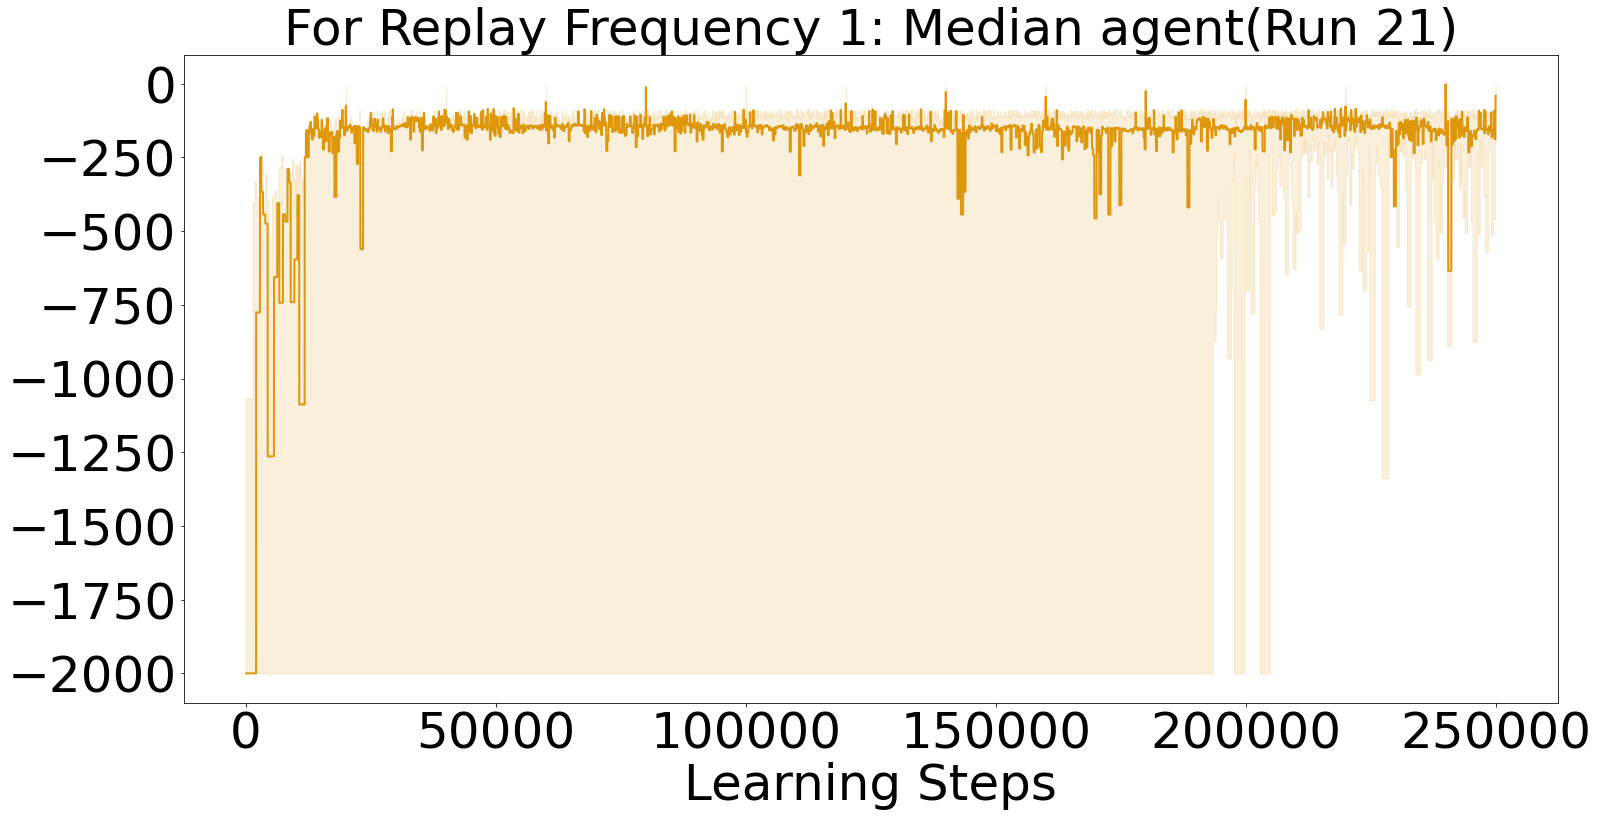

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_2.pkl
Total Runs:  30


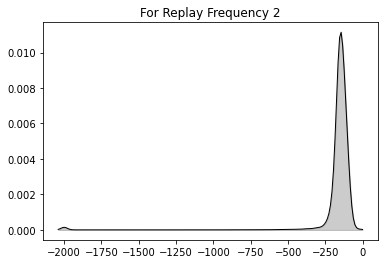

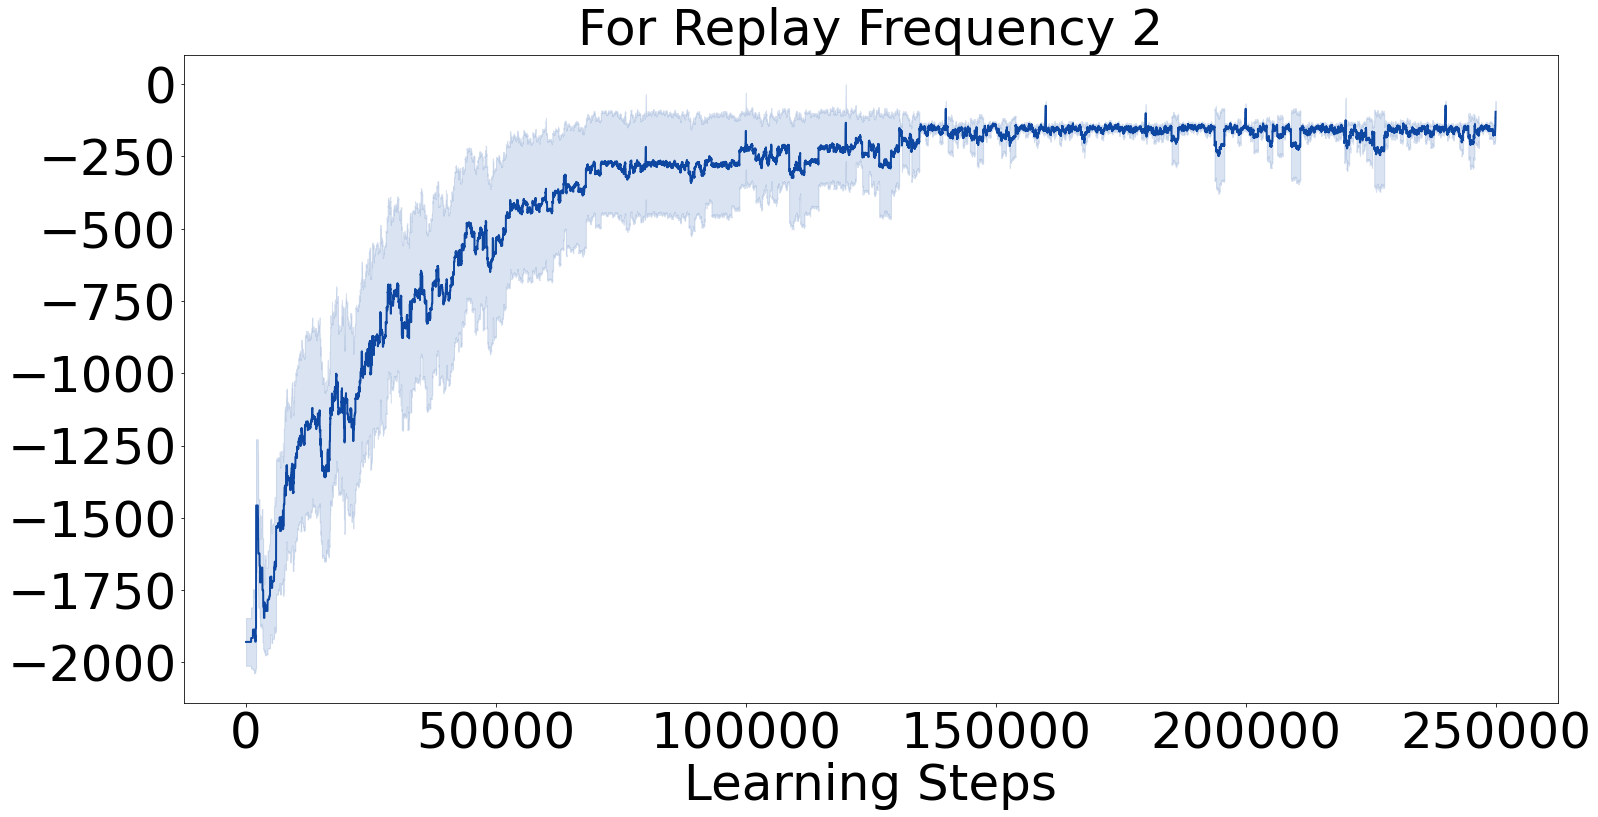

0 29


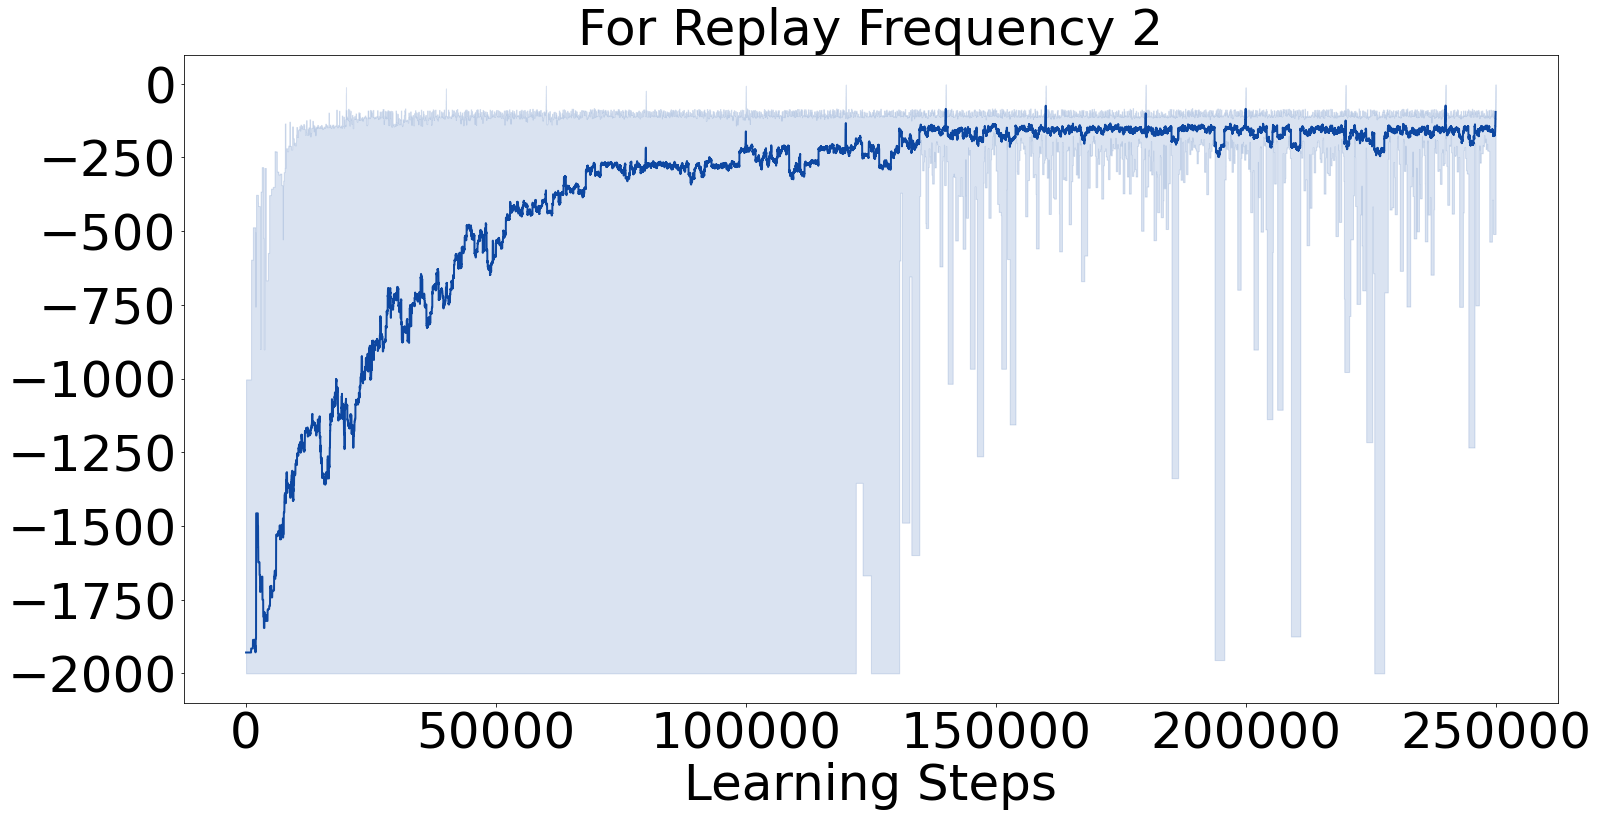

0 29


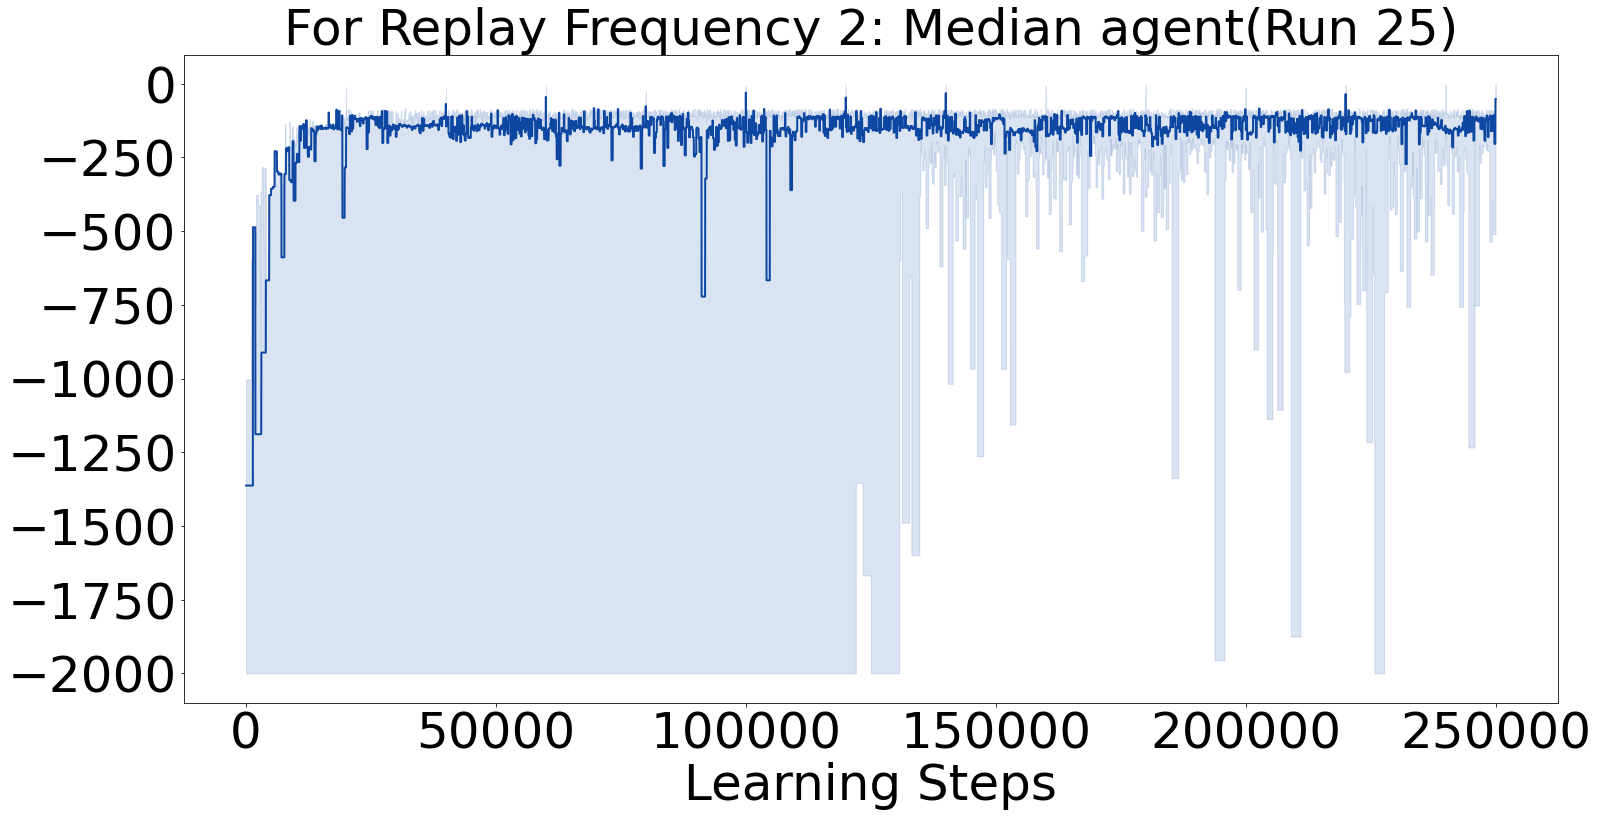

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_4.pkl
Total Runs:  30


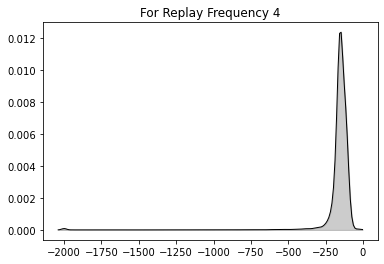

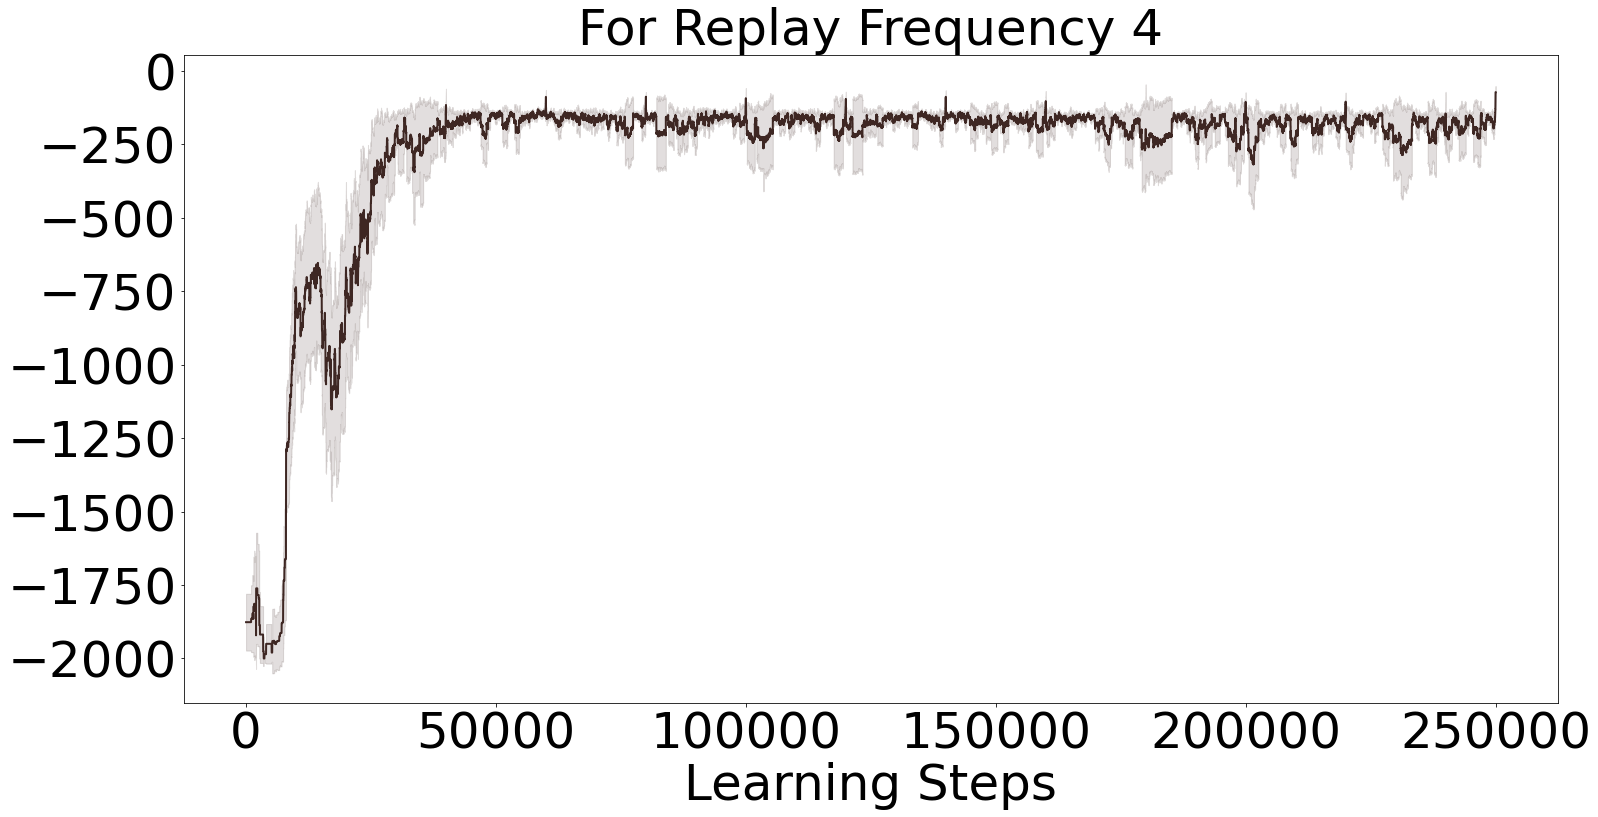

0 29


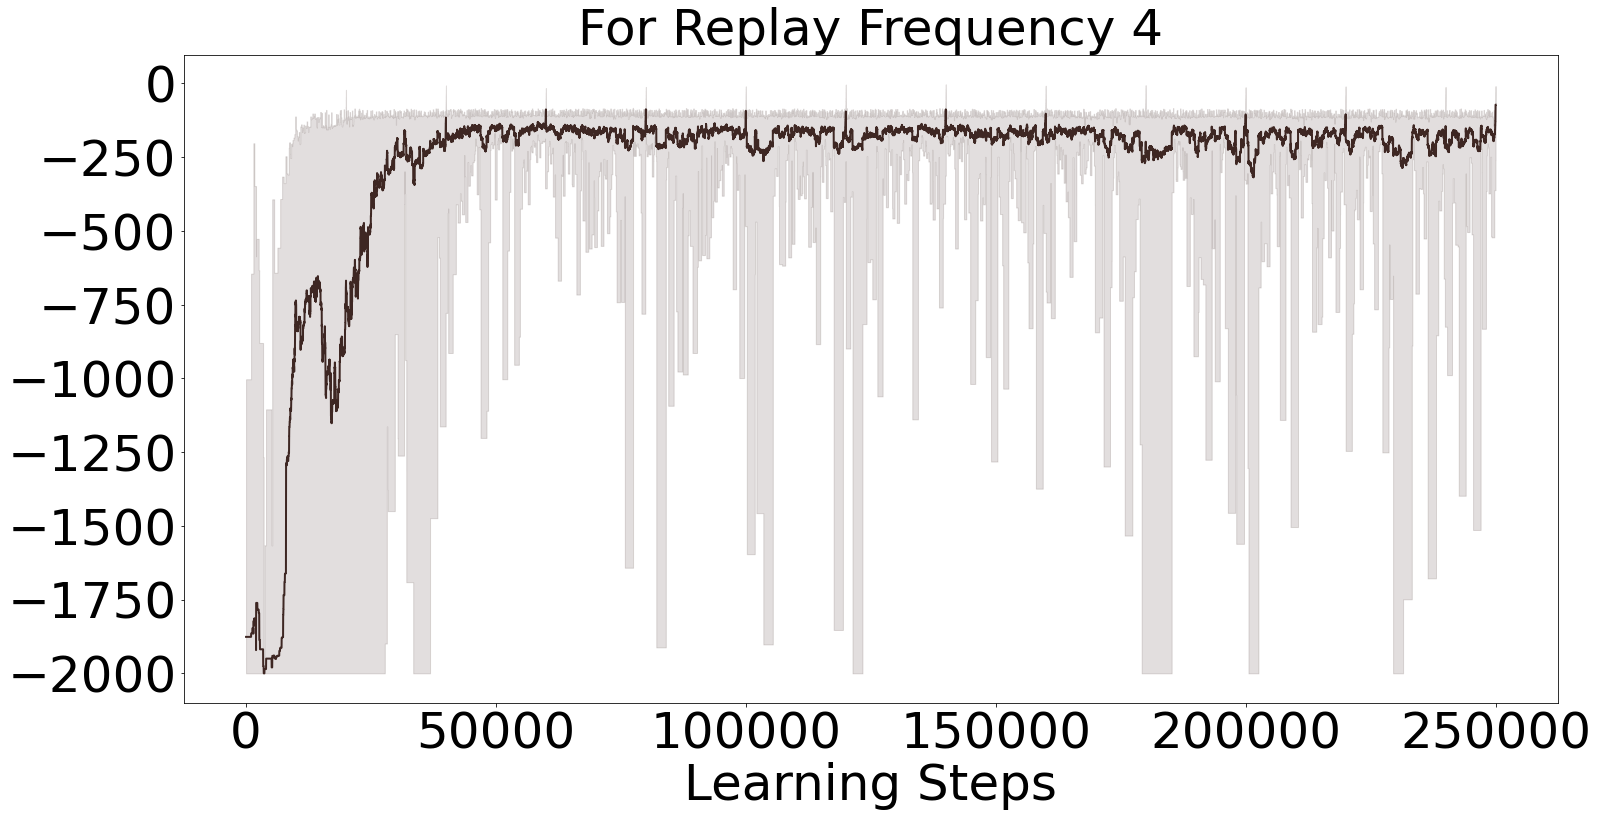

0 29


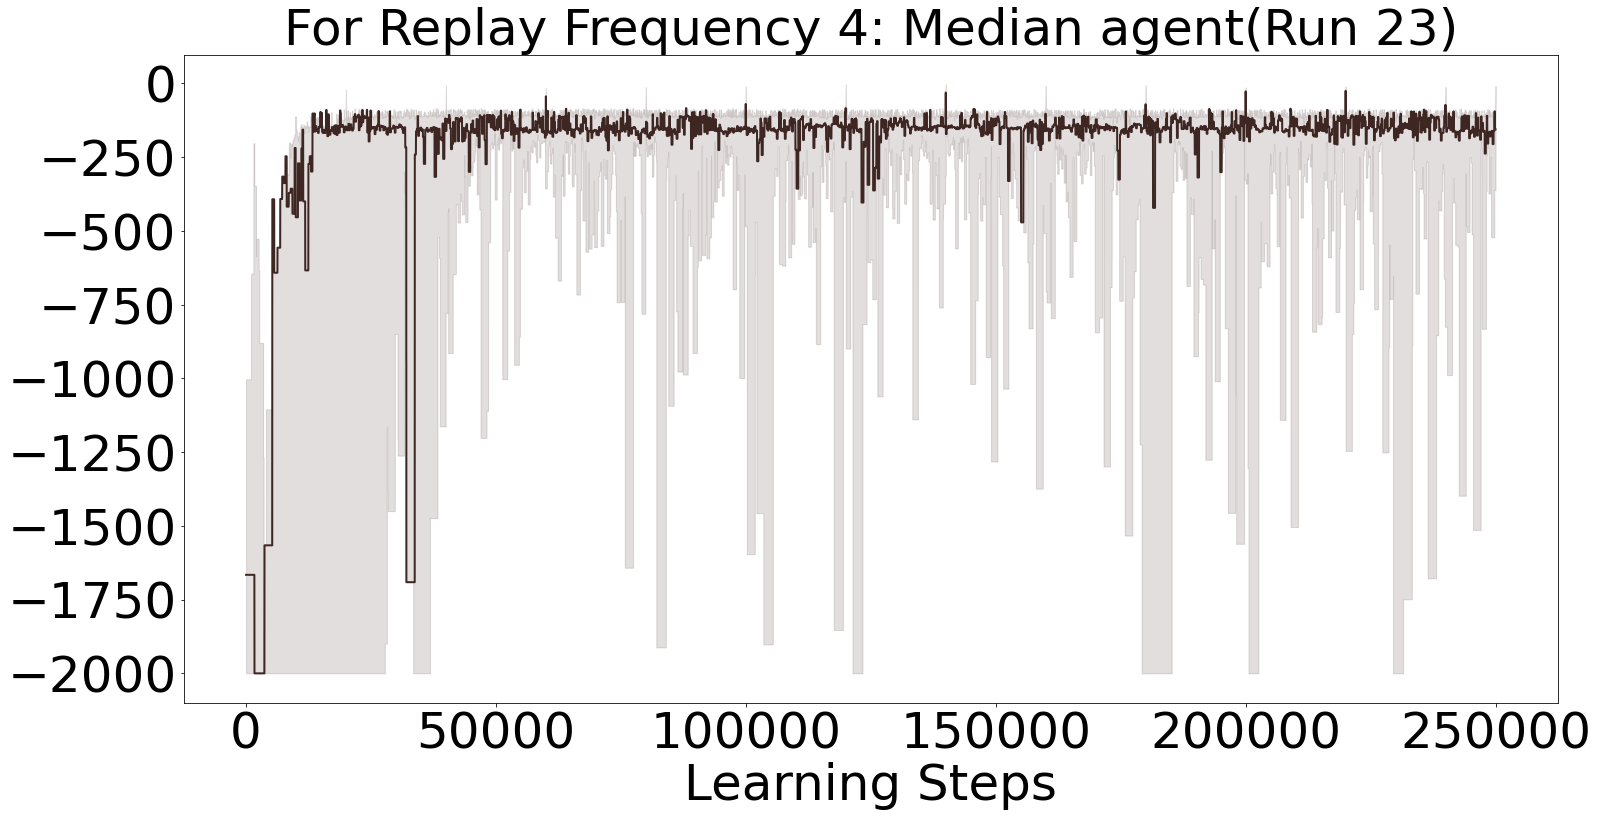

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_8.pkl
Total Runs:  30


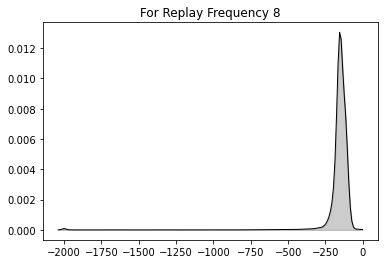

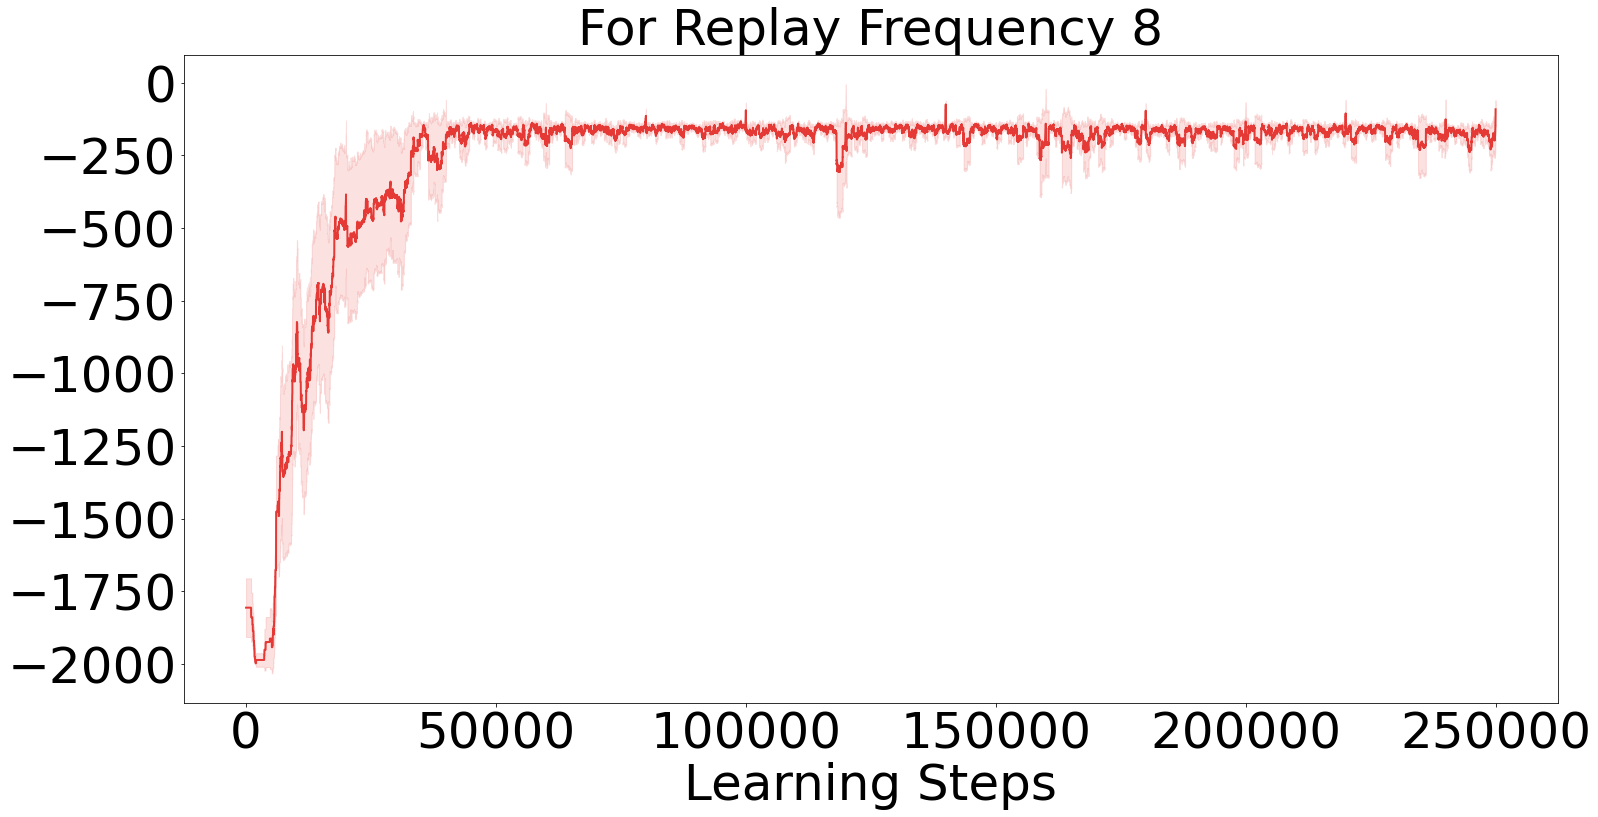

0 29


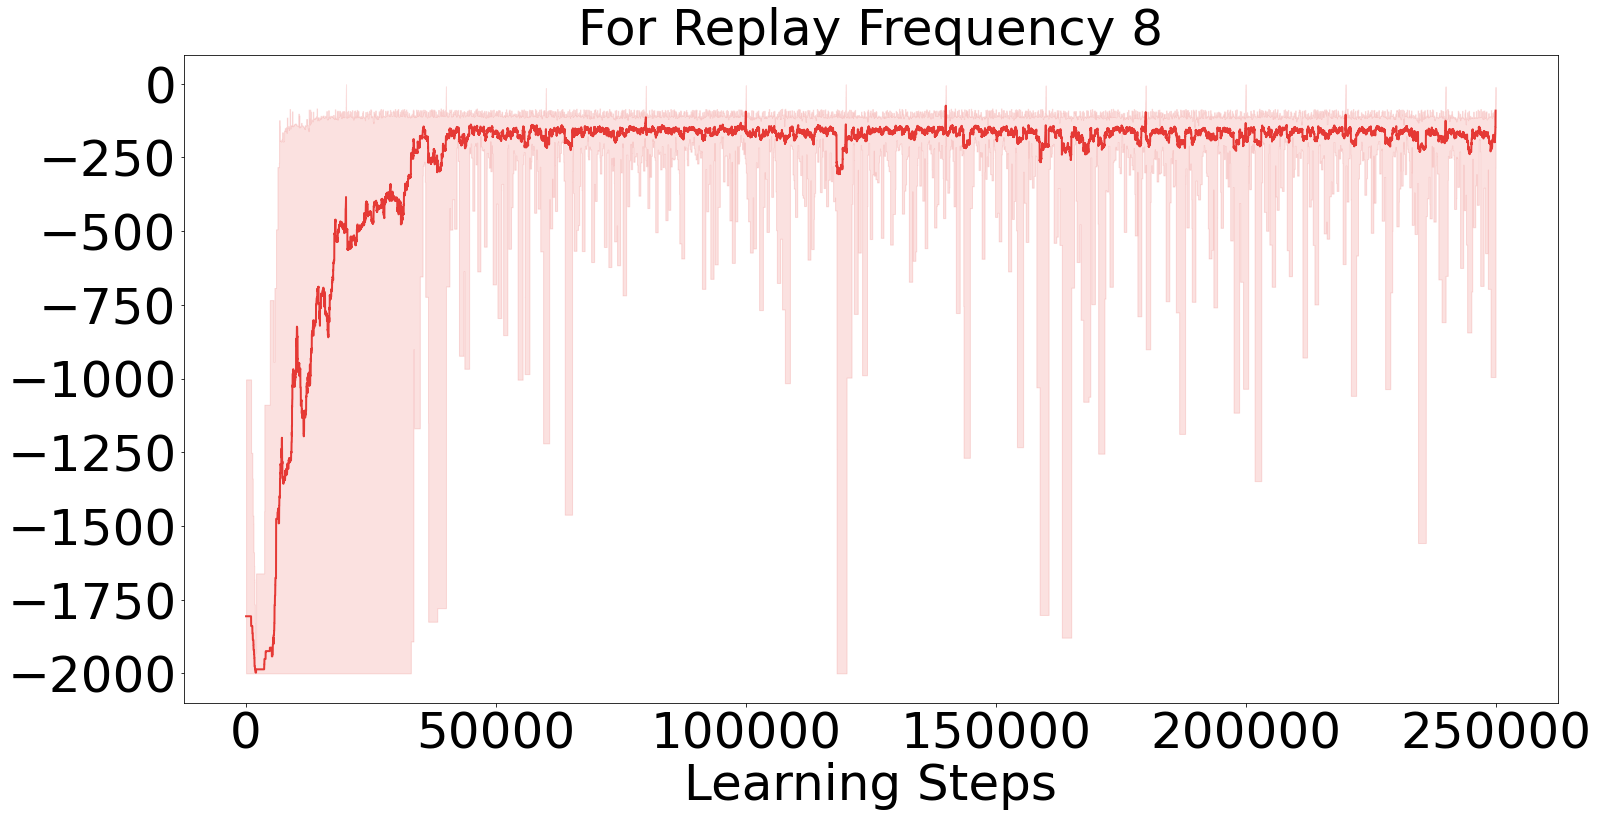

0 29


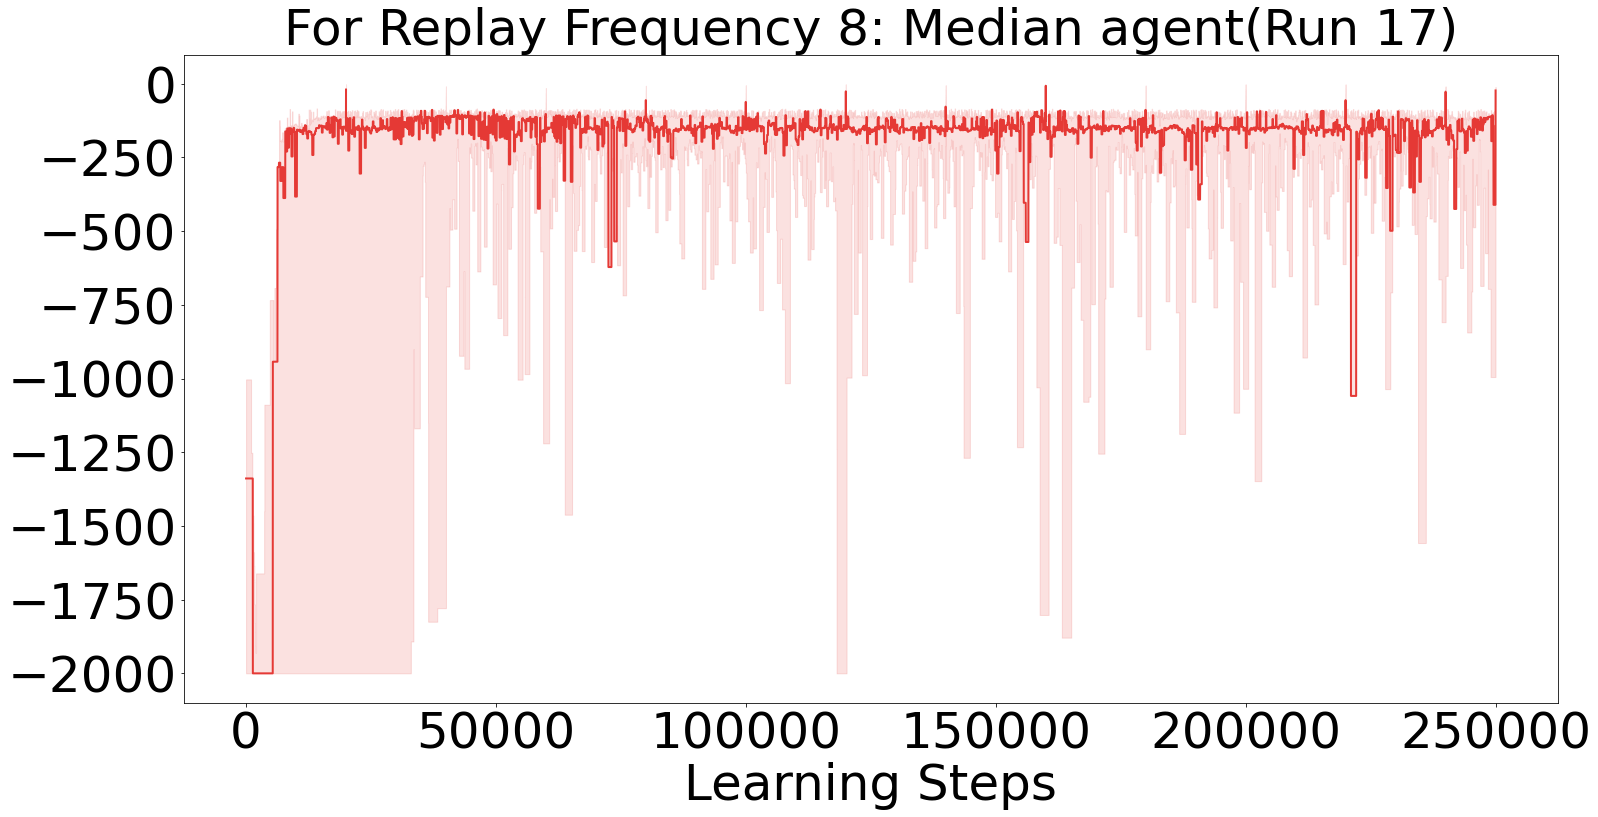

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_16.pkl
Total Runs:  30


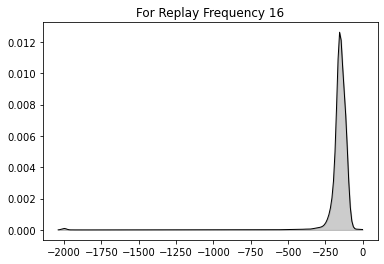

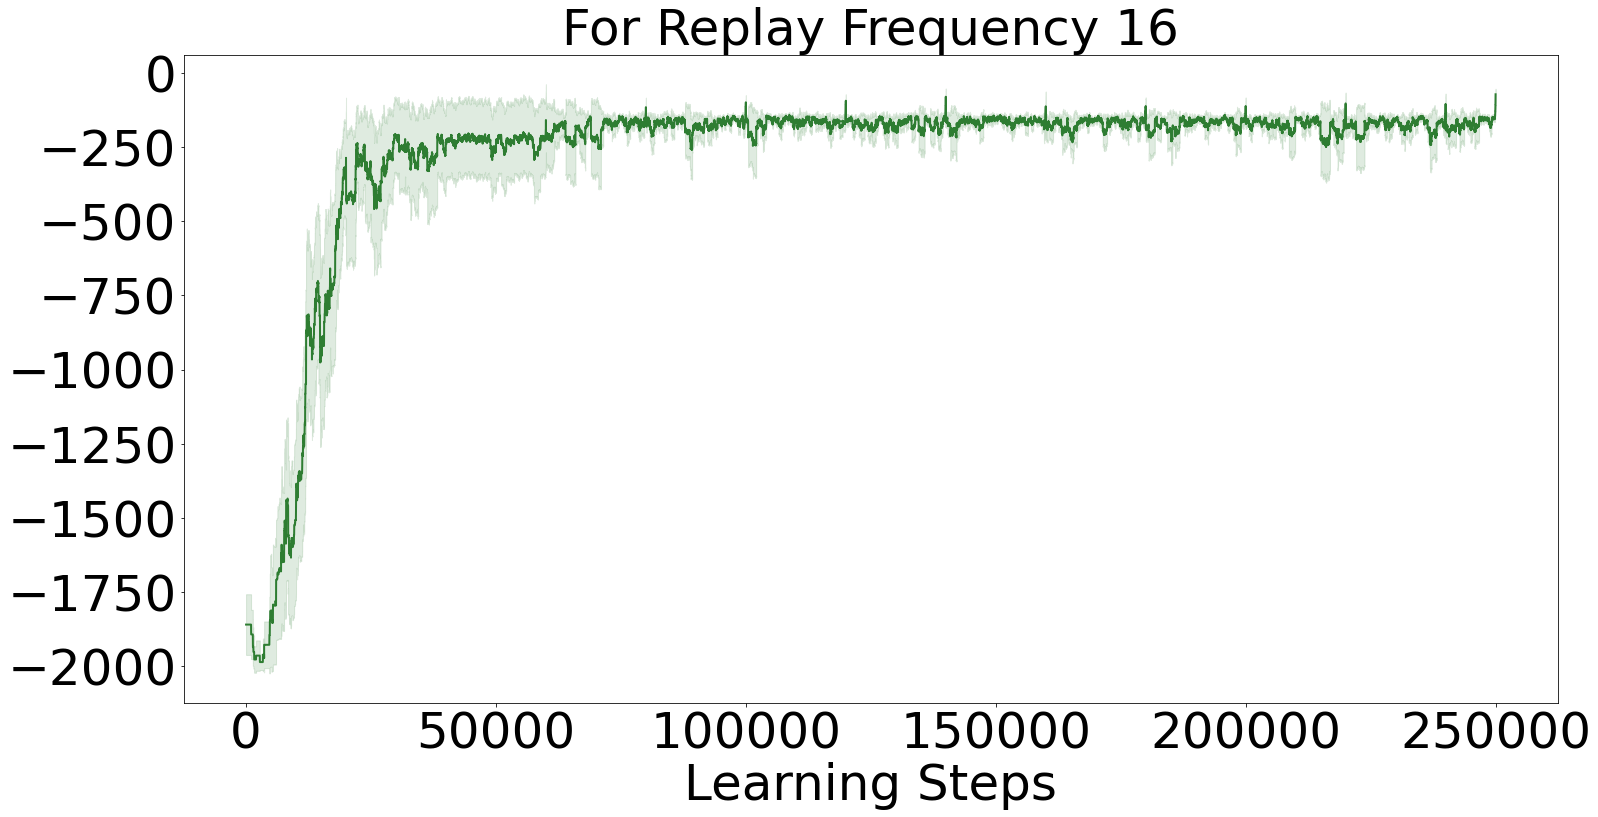

0 29


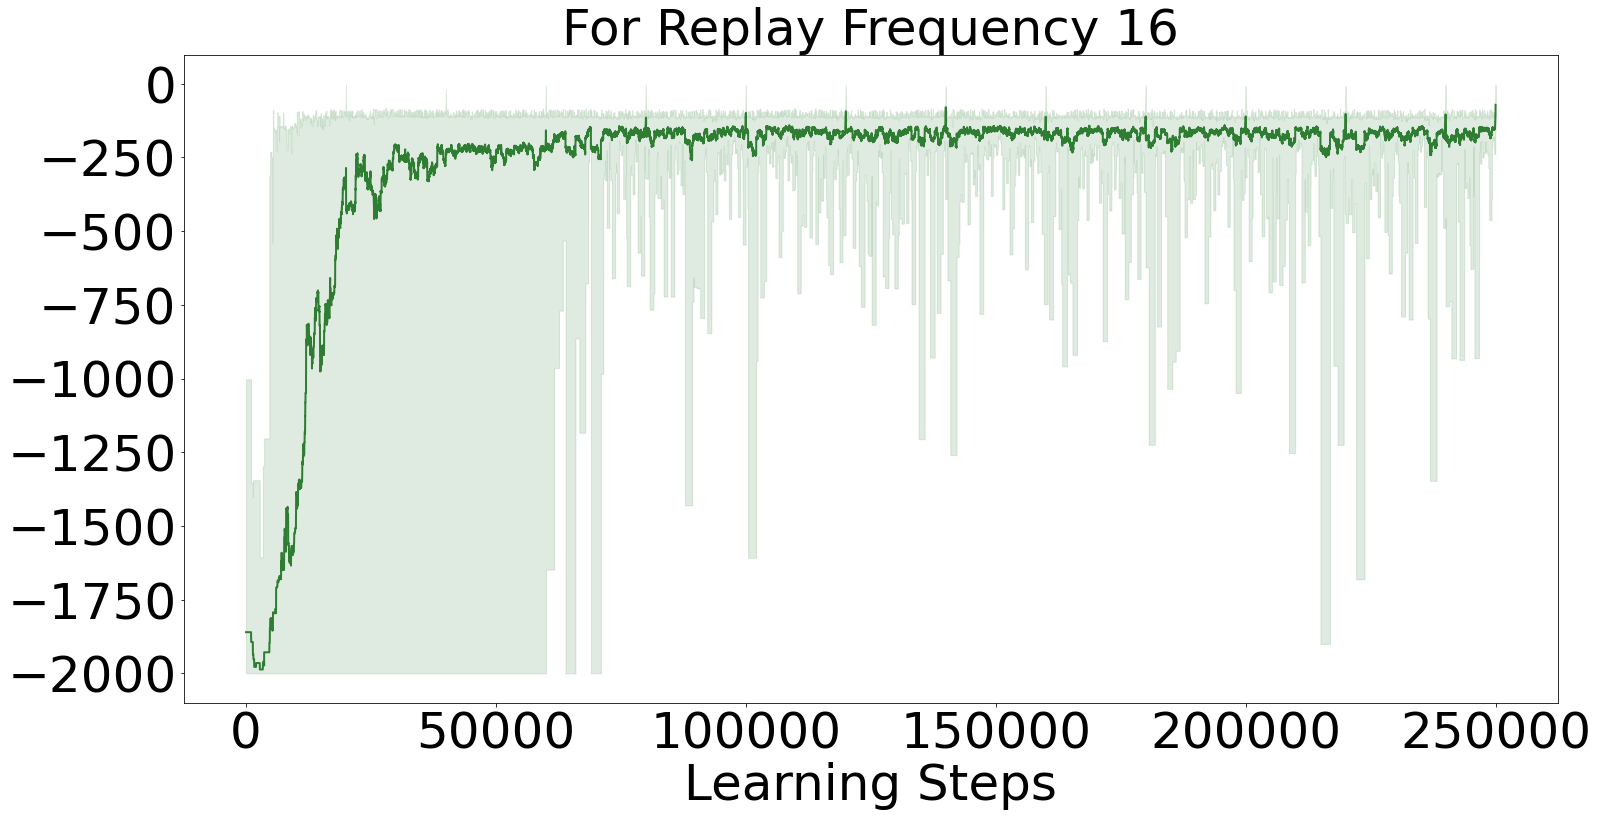

0 29


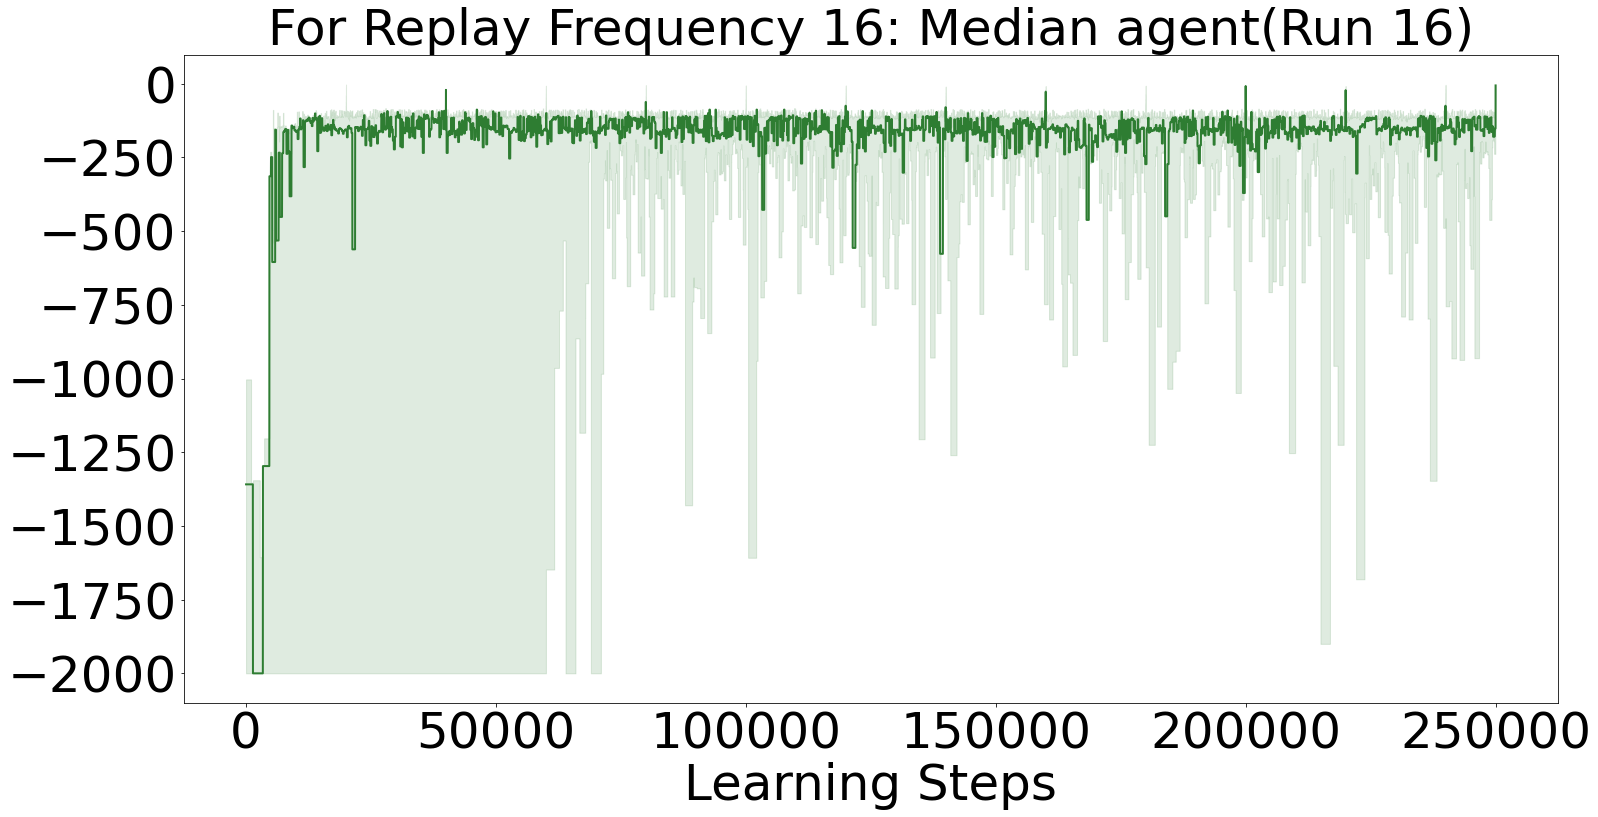

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_32.pkl
Total Runs:  30


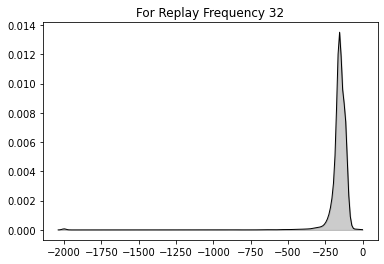

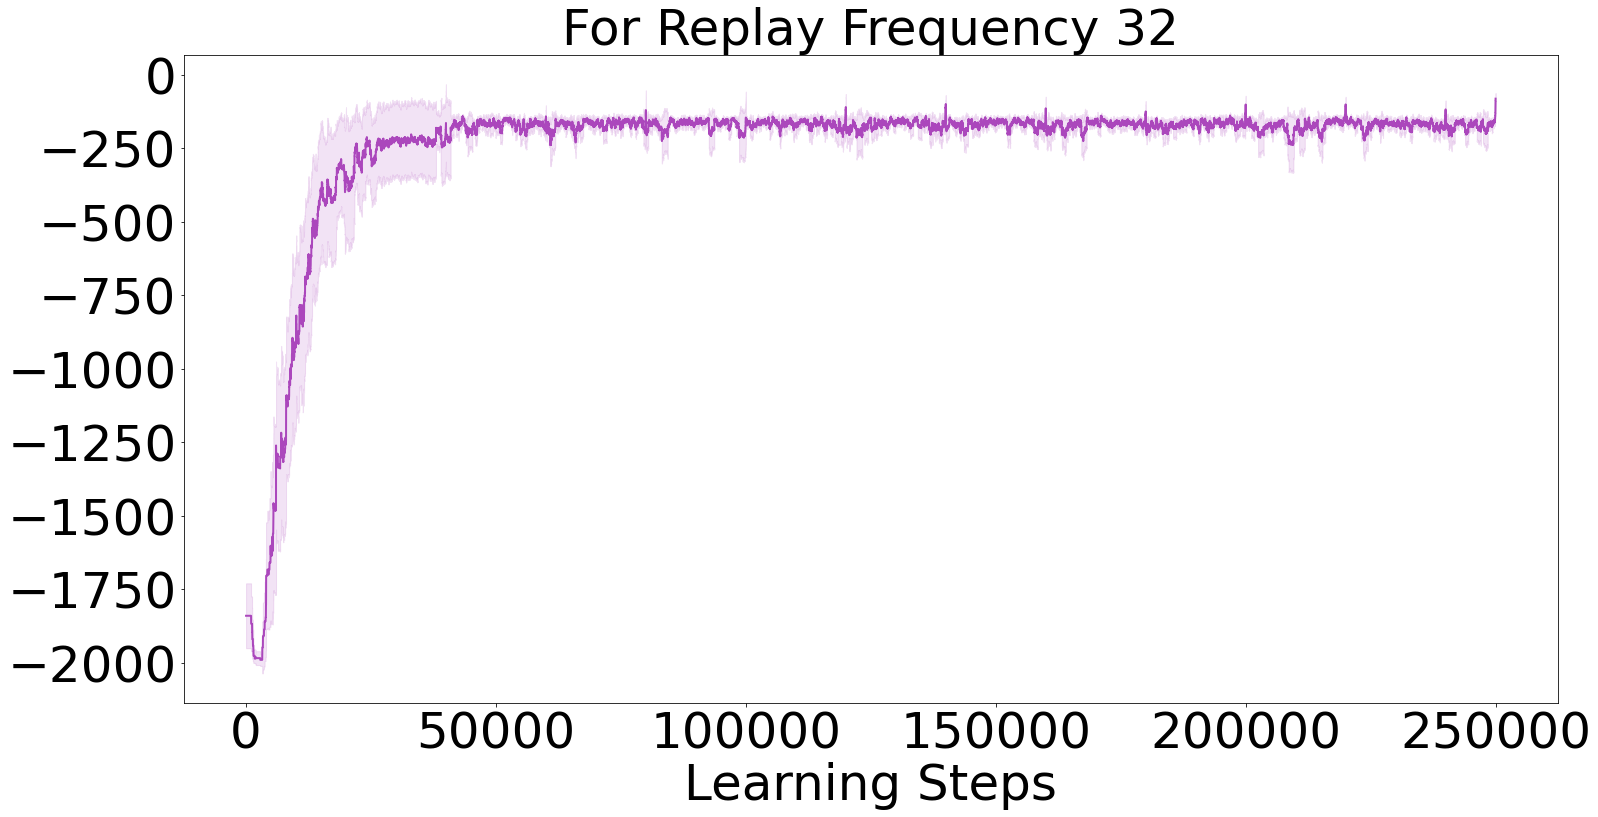

0 29


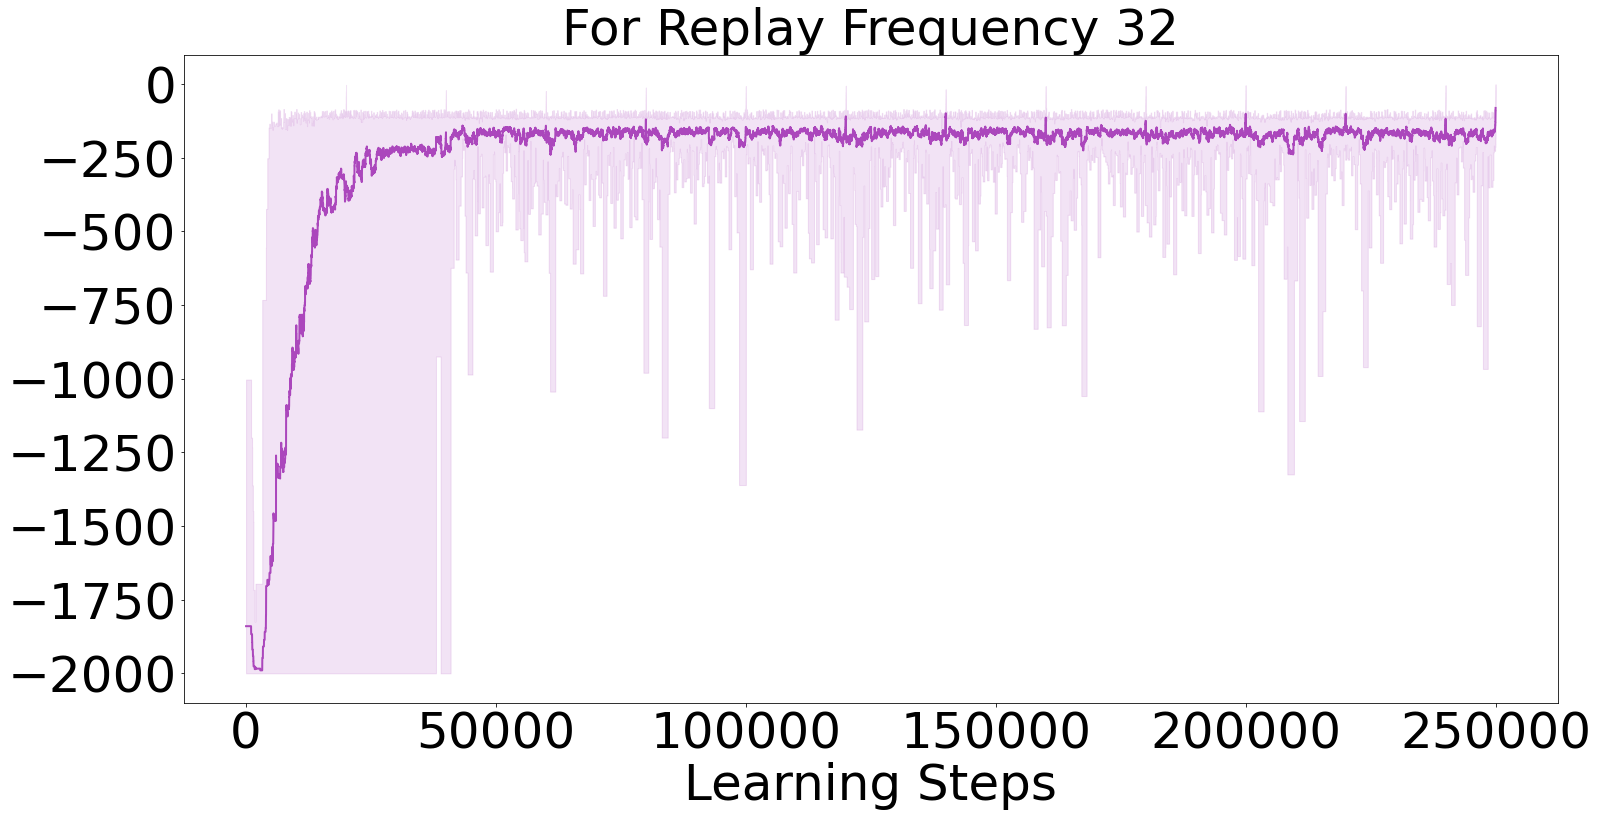

0 29


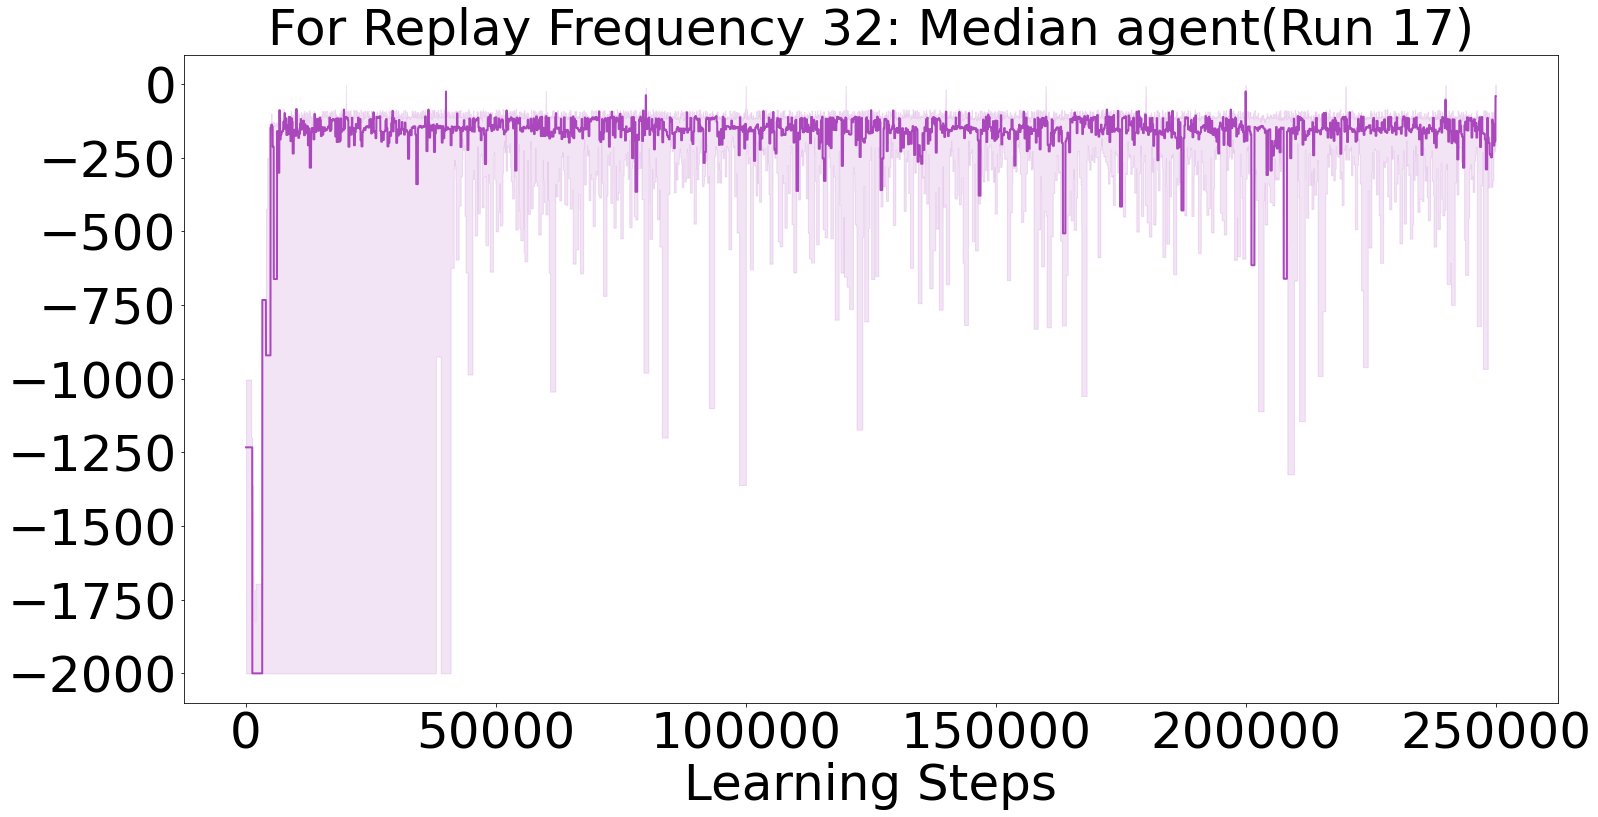

In [8]:
#runs = 30
replay_frequency_list = [1,2,4,8,16,32]
fsize = 50

col = ['#DE970B','#0D47A1','#3E2723','#E53935','#2E7D32','#AB47BC']
left=0.12
right=0.95
top=0.9
bottom=0.15

for i, replay in enumerate(replay_frequency_list):
    path_file = data_path+ "\log_train_rf_" + str(replay) + '.pkl'
    print(path_file)
    log_train = load_path_obj(path_file)
    
    log_train_EpisodeReturn = log_train[log_train['Metric']=="EpisodeReturns"].reset_index(drop=True)
    total_runs = np.unique(log_train_EpisodeReturn['Run']).shape[0]
    print('Total Runs: ', str(total_runs))
    
    #Distribution Graph
    points = log_train_EpisodeReturn['Undiscount_Return'].tolist()
    lo = pullLeft(np.min(points), 0.02)
    hi = pullRight(np.max(points), 0.02)
    
    kde = gaussian_kde(points)
    dist_space = np.linspace(lo, hi, fidelity)
    dist = kde(dist_space)
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Reward_distribution_Rf_"+str(replay)+"_runs_"+str(total_runs)+".pdf")
    fig, ax = plt.subplots()
    
    art, = ax.plot(dist_space, dist, linewidth=1.0, color='black', alpha=alpha)

    art = ax.fill_between(dist_space, np.zeros(fidelity), dist, color='black', alpha=0.2 * alpha)
    plt.title('For Replay Frequency '+str(replay))

    plt.show()
    plt.close()
    pdf.savefig(fig )
    pdf.close()
    
    #Confidence Interval
    episodic_return = np.zeros((total_runs, total_steps))

    for r in range(total_runs):
        log_train_EpisodeReturn_PerRun = log_train_EpisodeReturn[log_train_EpisodeReturn['Run']==r+1].reset_index(drop=True)
        single_run_history = np.zeros(total_steps)
        previous_position = 0

        for e in range(log_train_EpisodeReturn_PerRun['Run'].shape[0]):
            temp = np.full((1, log_train_EpisodeReturn_PerRun['Step'][e] - previous_position), log_train_EpisodeReturn_PerRun['Undiscount_Return'][e])

            np.put(single_run_history, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e]),temp)
            previous_position = log_train_EpisodeReturn_PerRun['Step'][e]

        episodic_return[r]= single_run_history

    mean = np.mean(episodic_return,axis=0)
    ste = sem(episodic_return,axis=0)
    (low_ci, high_ci) = confidenceInterval(mean, ste, total_runs)
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Confidence_Interval_Rf_"+str(replay)+"_runs_"+str(total_runs)+".pdf")
    fig, ax = plt.subplots(figsize=(23,12))

    p1 = ax.fill_between(range(mean.shape[0]), low_ci, high_ci, color = col[i], alpha=0.15)
    p2 = ax.plot(range(mean.shape[0]), mean, linewidth=2, color = col[i], label ='Relay Frequency '+ str(replay) )


    plt.title('For Replay Frequency '+str(replay), size = fsize)
    plt.xlabel("Learning Steps",size = fsize)
    plt.tight_layout()
    plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom)
    plt.xticks(size = fsize)
    plt.yticks(size = fsize)
    plt.show()

    plt.close()
    pdf.savefig(fig)
    pdf.close()
    
    
    #Tolerance Interval
    low_ti,mean_ti, high_ti = toleranceIntervalOverCurve (episodic_return)
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Tolerance_Interval_Rf_"+str(replay)+"_runs_"+str(total_runs)+".pdf")
    fig, ax = plt.subplots(figsize=(23,12))

    p1 = ax.fill_between(range(low_ti.shape[0]), low_ti, high_ti, color = col[i], alpha=0.15)
    p2 = ax.plot(range(low_ti.shape[0]), mean_ti, linewidth=2, color = col[i], label ='Relay Frequency '+ str(replay) )

    plt.title('For Replay Frequency '+str(replay), size = fsize)
    plt.xlabel("Learning Steps",size = fsize)
    plt.tight_layout()
    plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom)
    plt.xticks(size = fsize)
    plt.yticks(size = fsize)
    plt.show()

    plt.close()
    pdf.savefig(fig )
    pdf.close()
    
    #Tolerance Interval with median line
    low_ti,mean_ti, high_ti = toleranceIntervalOverCurve (episodic_return)
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Tolerance_Interval_with_Median_Rf_"+str(replay)+"_runs_"+str(total_runs)+".pdf")
    fig, ax = plt.subplots(figsize=(23,12))
    
    p1 = ax.fill_between(range(low_ti.shape[0]), low_ti, high_ti, color = col[i], alpha=0.15)
    median_index = episodic_return.mean(axis=1).argsort()[::-1][0]
    p2 = ax.plot(range(low_ti.shape[0]), episodic_return[median_index], linewidth=2, color = col[i], label ='Relay Frequency '+ str(replay) )

    plt.title('For Replay Frequency '+str(replay)+": Median agent(Run " + str(median_index+1) +")", size = fsize)
    plt.xlabel("Learning Steps",size = fsize)
    plt.tight_layout()
    plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom)
    plt.xticks(size = fsize)
    plt.yticks(size = fsize)
    plt.show()

    plt.close()
    pdf.savefig(fig )
    pdf.close()
    
    

### Sensitivity Curve

In [66]:
#runs = 15
replay_frequency_list = [1,2,4,8,16,32]
total_runs = 30

In [67]:
average_undiscounted_return = []
starndard_error_undiscounted_return = []

for i, replay in enumerate(replay_frequency_list):
    path_file = data_path + "\lr_0.001_bs_32_tus_128\log_train_rf_" + str(replay) + '.pkl'
    print(path_file)
    log_train = load_path_obj(path_file)
    
    log_train_EpisodeReturn = log_train[log_train['Metric']=="EpisodeReturns"].reset_index(drop=True)
    #total_runs = 30#np.unique(log_train_EpisodeReturn['Run']).shape[0]
    episodic_return = np.zeros((total_runs, total_steps))
    
    for r in range(total_runs):
        log_train_EpisodeReturn_PerRun = log_train_EpisodeReturn[log_train_EpisodeReturn['Run']==r+1].reset_index(drop=True)
        single_run_history = np.zeros(total_steps)
        previous_position = 0

        for e in range(log_train_EpisodeReturn_PerRun['Run'].shape[0]):
            temp = np.full((1, log_train_EpisodeReturn_PerRun['Step'][e] - previous_position), log_train_EpisodeReturn_PerRun['Undiscount_Return'][e])

            np.put(single_run_history, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e]),temp)
            previous_position = log_train_EpisodeReturn_PerRun['Step'][e]

        #np.put(episodic_return, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e+1]),temp)
       
        episodic_return[r]= single_run_history
    print(np.mean(episodic_return))
    #print(np.std())
    means_all_runs = np.mean(episodic_return, axis=1)
    starndard_error = np.std(means_all_runs, ddof=1) / np.sqrt(np.size(means_all_runs))
    print(starndard_error)
    starndard_error_undiscounted_return.append(starndard_error)
    average_undiscounted_return.append(np.mean(episodic_return))

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_tus_128\log_train_rf_1.pkl
-622.6209733333334
71.98853510087065
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_tus_128\log_train_rf_2.pkl
-378.68031226666665
38.31629297094272
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_tus_128\log_train_rf_4.pkl
-282.68357733333335
9.354067538732174
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_tus_128\log_train_rf_8.pkl
-269.37270586666665
11.805504992022321
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_tus_128\log_train_rf_16.pkl
-279.53648826666665
14.375881753318124
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_t

In [39]:
t = np.mean(episodic_return, axis=1)

In [45]:
np.mean(episodic_return)

-245.93761733333332

In [30]:
#plt.errorbar(x, y, yerr=dy, fmt='.k');

In [31]:
data_path

'C:\\Users\\anime\\UofA\\Thesis\\RL\\Adam_UofA\\Project\\CMPUT_655_project_results_shared_folder\\plotting'

In [56]:
average_undiscounted_return

[-622.6209733333334,
 -378.68031226666665,
 -282.68357733333335,
 -269.37270586666665,
 -279.53648826666665,
 -245.93761733333332]

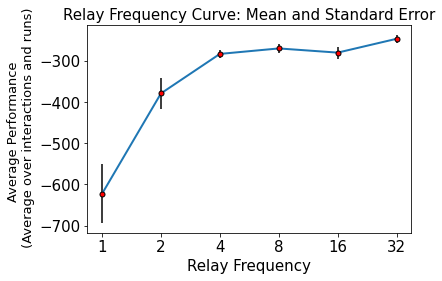

In [79]:
from matplotlib.ticker import ScalarFormatter
pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Relay Frequency Curve.pdf")
fsize = 15
fig, ax = plt.subplots()
#base, = ax.plot(mean, label=None, linewidth=2)

p2 = ax.plot(replay_frequency_list, average_undiscounted_return, linewidth=2) #,marker ='o',markersize=5,markerfacecolor='red')

plt.errorbar(replay_frequency_list, average_undiscounted_return, yerr=starndard_error_undiscounted_return, markersize=5, marker='o', markerfacecolor = 'red', color = 'black',fmt='.k');
plt.title('Relay Frequency Curve: Mean and Standard Error', size = fsize)
plt.xlabel("Relay Frequency",size = fsize)
plt.ylabel("Average Performance \n (Average over interactions and runs)",size = 13)

plt.tight_layout()
plt.subplots_adjust(left=0.20, right=0.95, top=0.9, bottom=0.18)
plt.xticks(size = fsize)
plt.xscale('log',base=2)
plt.yticks(size = fsize)
ax.set_xticks(replay_frequency_list)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.show()

plt.close()
pdf.savefig(fig)
pdf.close()

In [82]:
starndard_error_undiscounted_return

[71.98853510087065,
 38.31629297094272,
 9.354067538732174,
 11.805504992022321,
 14.375881753318124,
 9.552048444183715]

In [83]:
starndard_error_undiscounted_return_t_test = np.array(starndard_error_undiscounted_return) * 2.045

In [86]:
starndard_error_undiscounted_return_t_test = starndard_error_undiscounted_return_t_test.tolist()

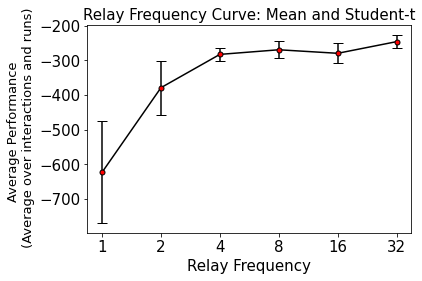

In [96]:
from matplotlib.ticker import ScalarFormatter
pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Relay Frequency Curve.pdf")
fsize = 15
fig, ax = plt.subplots()
#base, = ax.plot(mean, label=None, linewidth=2)

#p2 = ax.plot(replay_frequency_list, average_undiscounted_return, linewidth=2,marker ='o',markersize=5,markerfacecolor='red')

plt.errorbar(replay_frequency_list, average_undiscounted_return, yerr=starndard_error_undiscounted_return_t_test, markersize=5, marker='o', markerfacecolor = 'red', color = 'black',fmt='-o',capsize=5);
plt.title('Relay Frequency Curve: Mean and Student-t', size = fsize)
plt.xlabel("Relay Frequency",size = fsize)
plt.ylabel("Average Performance \n (Average over interactions and runs)",size = 13)

plt.tight_layout()
plt.subplots_adjust(left=0.20, right=0.95, top=0.9, bottom=0.18)
plt.xticks(size = fsize)
plt.xscale('log',base=2)
plt.yticks(size = fsize)
ax.set_xticks(replay_frequency_list)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.show()

plt.close()
pdf.savefig(fig)
pdf.close()

### Sensitivity Curve for a particular replay frequency

In [8]:
learning_rate_list = [0.1,0.01,0.001,0.0001]
replay = 1
average_undiscounted_return = []
total_runs = 30

for i, lr in enumerate(learning_rate_list):
    path_file = data_path+ "\lr_"+str(lr)+"_bs_32_tus_128" + "\log_train_rf_" + str(replay) + '.pkl'
    print(path_file)
    log_train = load_path_obj(path_file)
    
    log_train_EpisodeReturn = log_train[log_train['Metric']=="EpisodeReturns"].reset_index(drop=True)
    #total_runs = 30#np.unique(log_train_EpisodeReturn['Run']).shape[0]
    episodic_return = np.zeros((total_runs, total_steps))
    
    for r in range(total_runs):
        log_train_EpisodeReturn_PerRun = log_train_EpisodeReturn[log_train_EpisodeReturn['Run']==r+1].reset_index(drop=True)
        single_run_history = np.zeros(total_steps)
        previous_position = 0

        for e in range(log_train_EpisodeReturn_PerRun['Run'].shape[0]):
            temp = np.full((1, log_train_EpisodeReturn_PerRun['Step'][e] - previous_position), log_train_EpisodeReturn_PerRun['Undiscount_Return'][e])

            np.put(single_run_history, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e]),temp)
            previous_position = log_train_EpisodeReturn_PerRun['Step'][e]

        #np.put(episodic_return, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e+1]),temp)
       
        episodic_return[r]= single_run_history
    print(np.mean(episodic_return))
    average_undiscounted_return.append(np.mean(episodic_return))
    

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.1_bs_32_tus_128\log_train_rf_1.pkl
-1952.4620906666667
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.01_bs_32_tus_128\log_train_rf_1.pkl
-792.5691389333333
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.001_bs_32_tus_128\log_train_rf_1.pkl
-622.6209733333334
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\lr_0.0001_bs_32_tus_128\log_train_rf_1.pkl
-1619.9402424


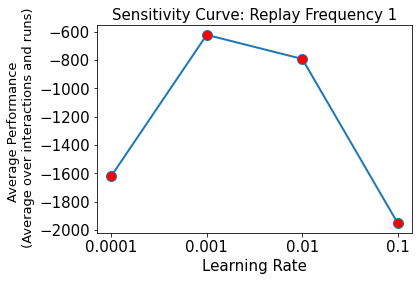

In [20]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter


pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Sensitivity_Curve_learning_rate_rf_"+str(replay) +".pdf")
fsize = 15
fig, ax = plt.subplots()
#base, = ax.plot(mean, label=None, linewidth=2)
x_axis = learning_rate_list


p2 = ax.plot(x_axis, average_undiscounted_return, linewidth=2,marker ='o',markersize=10,markerfacecolor='red')


plt.title('Sensitivity Curve: Replay Frequency '+ str(replay), size = fsize)
plt.xlabel("Learning Rate",size = fsize)
plt.ylabel("Average Performance \n (Average over interactions and runs)",size = 13)

plt.tight_layout()
plt.subplots_adjust(left=0.22, right=0.95, top=0.9, bottom=0.18)
plt.xticks(size = fsize)
plt.xscale('log',base=2)
plt.yticks(size = fsize)
ax.set_xticks(x_axis)

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))

#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())

plt.show()

plt.close()
pdf.savefig(fig)
pdf.close()

In [10]:
average_undiscounted_return

[-1952.4620906666667, -792.5691389333333, -622.6209733333334, -1619.9402424]